In [10]:
import pandas as pd
import json
pd.set_option('display.max_columns', 500)

# df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/eth_cbbtc_usdt.csv")
df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/eth_cbbtc_usdc.csv")
# df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/base_cbbtc_usdc_full.csv")
df = df[df["datetime"] < "2026-01-01"]
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/markets_meta.json", 'r') as f:
    markets_meta = json.load(f)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/assets_meta.json", 'r') as f:
    assets_meta = json.load(f)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/vaults_meta.json", 'r') as f:
    vaults_meta = json.load(f)
market_addr = df["market_address"].unique()[0]
market_meta = markets_meta[market_addr]
asset_meta = assets_meta[market_meta["collateral_asset_address"]]
loan_asset_meta = assets_meta[market_meta["loan_asset_address"]]
loan_asset_meta["decimals"] = 6
all_vaults_addresses = vaults_meta.keys()
asset_price_df = pd.DataFrame(asset_meta["historical_price"], columns=["timestamp", "price"]).dropna()

# df = df[:200000]

market_meta

{'address': '0x64d65c9a2d91c36d56fbc42d69e979335320169b3df63bf92789e2c8883fcc64',
 'lltv': '860000000000000000',
 'oracle_address': '0xA6D6950c9F177F1De7f7757FB33539e3Ec60182a',
 'creation_datetime': 1725479483,
 'network': 'eth',
 'loan_asset_address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
 'loan_asset_symbol': 'USDC',
 'loan_asset_decimals': 6,
 'collateral_asset_address': '0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf',
 'collateral_asset_symbol': 'cbBTC',
 'collateral_asset_decimals': 8,
 'rate_at_target': {'1771765200': 1120370386,
  '1771761600': 1120354654,
  '1771758000': 1120396548,
  '1771754400': 1120447857,
  '1771750800': 1120504051,
  '1771747200': 1120560610,
  '1771743600': 1120709018,
  '1771740000': 1120859983,
  '1771736400': 1121007095,
  '1771732800': 1121168732,
  '1771729200': 1121325638,
  '1771725600': 1121493952,
  '1771722000': 1121672345,
  '1771718400': 1121852331,
  '1771714800': 1122032836,
  '1771711200': 1122217189,
  '1771707600': 1122404340,
  '1

In [2]:

import numpy as np

def compute_market_rates(market_params, fee=0.0):
    """
    For each timestamp in market_params['rate_at_target'], compute borrow & supply APR
    for all utilizations from 0% to 100% (1% steps).

    Parameters:
        market_params : dict with 'rate_at_target' key mapping timestamp -> rate (scaled by 1e18)
        fee : market fee (0..1), default 0.0

    Returns:
        dict : timestamp -> list of [util%, borrowAPR%, supplyAPR%] for util 0..100
    """
    rate_dict = market_params.get('rate_at_target', {})
    if not rate_dict:
        return {}

    SECONDS_PER_YEAR = 365 * 86400
    TARGET = 0.9
    KD = 4.0

    # Utilization values from 0 to 1 (inclusive) step 0.01
    utils = np.arange(0, 1.01, 0.01)
    util_percent = utils * 100

    result = {}
    for ts, rate_wad in rate_dict.items():
        # Convert rate from WAD (1e18) to decimal per second
        if rate_wad is None:
            continue
        rate_per_sec = rate_wad / 1e18

        # Compute error e and curve for all utilizations
        e = np.where(
            utils <= TARGET,
            (utils - TARGET) / TARGET,
            (utils - TARGET) / (1 - TARGET)
        )
        curve = np.where(
            utils <= TARGET,
            (1 - 1/KD) * e + 1,
            (KD - 1) * e + 1
        )

        # Borrow rate per second
        borrow_rate_ps = rate_per_sec * curve

        # Supply rate per second
        supply_rate_ps = borrow_rate_ps * utils * (1 - fee)

        # Convert to APR percent
        borrow_apr = borrow_rate_ps * SECONDS_PER_YEAR
        supply_apr = supply_rate_ps * SECONDS_PER_YEAR

        # Build list of [util%, borrow%, supply%]
        result[int(ts)] = [
            [util_percent[i], borrow_apr[i], supply_apr[i]]
            for i in range(len(utils))
        ]

    return result
market_irm_rates = compute_market_rates(market_meta)

In [38]:
min(market_irm_rates.keys())

1725480000

In [3]:
import matplotlib.pyplot as plt
def plot_daily_metrics(df_orig, col="assets_usd", date_col="datetime", cutoff=None, agg_func='last'):
    df = df_orig.copy().fillna(0)
    df[date_col] = pd.to_datetime(df[date_col])
    
    df['date_only'] = df[date_col].dt.date
    
    if agg_func == 'last':
        df = df.sort_values(date_col)
        df = df.drop_duplicates(subset='date_only', keep='last')
    elif agg_func == 'mean':
        df = df.groupby('date_only')[col].mean().reset_index()
        df[date_col] = pd.to_datetime(df['date_only'])
    else:
        raise ValueError("agg_func must be 'last' or 'mean'")
    
    if cutoff is not None:
        df = df[df[date_col] >= cutoff]
    
    daily_df = df.groupby(date_col)[col].sum().reset_index()
    
    plt.figure(figsize=(14, 7))
    plt.plot(daily_df[date_col], daily_df[col], linewidth=2)
    
    plt.title(f'Daily {col} ({agg_func})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

def plot_daily_metrics_express(df_orig, cols=["assets_usd"], date_col="datetime", 
                               cutoff=None, agg_func='last', price_df=None, price_col='price'):
    df = df_orig.copy().fillna(0)
    df[date_col] = pd.to_datetime(df[date_col])
    df['date_only'] = df[date_col].dt.date
    
    if agg_func == 'last':
        df = df.sort_values(date_col)
        df = df.drop_duplicates(subset='date_only', keep='last')
    elif agg_func == 'mean':
        grouped = df.groupby('date_only')[cols].mean().reset_index()
        df = grouped.copy()
        df[date_col] = pd.to_datetime(df['date_only'])
    
    if cutoff is not None:
        df = df[df[date_col] >= cutoff]
    
    daily_df = df.groupby(date_col)[cols].sum().reset_index()
    
    # Add price data if provided
    if price_df is not None:
        price_df = price_df.copy()
        price_df['datetime'] = pd.to_datetime(price_df['datetime'])
        price_df['date_only'] = price_df['datetime'].dt.date
        
        # Filter price_df to only dates in daily_df
        valid_dates = daily_df[date_col].dt.date.unique()
        price_df = price_df[price_df['date_only'].isin(valid_dates)]
        
        if not price_df.empty:
            # Get latest price per date
            daily_price = price_df.sort_values('datetime').drop_duplicates('date_only', keep='last')
            daily_price = daily_price[['date_only', price_col]]
            daily_price[date_col] = pd.to_datetime(daily_price['date_only'])
            
            # Merge with daily_df
            daily_df = pd.merge(daily_df, daily_price, on=date_col, how='left')
            cols = cols + [price_col]
    
    melted_df = daily_df.melt(id_vars=[date_col], value_vars=cols, 
                            var_name='metric', value_name='value')
    
    fig = px.line(
        melted_df, 
        x=date_col, 
        y='value',
        color='metric',
        title=f'Daily Metrics ({agg_func})',
        labels={'value': 'Value', date_col: 'Date', 'metric': 'Metric'},
        hover_data={date_col: '|%Y-%m-%d', 'value': ':,.5f'}
    )
    
    # Add secondary y-axis for price if present
    if price_df is not None and price_col in daily_df.columns:
        fig.update_layout(
            yaxis=dict(title="Primary Metrics"),
            yaxis2=dict(
                title="Price",
                overlaying="y",
                side="right",
                showgrid=False
            )
        )
        # Update price trace to use secondary axis
        price_trace_idx = len(cols) - 1  # Last trace is price
        fig.data[price_trace_idx].update(yaxis="y2")
    
    fig.update_traces(
        mode='lines+markers',
        line=dict(width=2),
        marker=dict(size=4),
        hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +
                     '<b>%{fullData.name}:</b> %{y:,.5f}<br>' +
                     '<extra></extra>'
    )
    
    fig.update_layout(
        width=1000,
        height=500,
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        plot_bgcolor='white'
    )
    
    fig.show()

import plotly.express as px
import pandas as pd

def plot_metrics_timeseries(df_orig, col="assets_usd", date_col="datetime", cutoff=None):
    """
    Plot metrics as a timeseries with each row represented, sorted by timestamp.
    
    Parameters:
    - df_orig: DataFrame containing the data
    - col: Column name to plot
    - date_col: Name of the datetime column
    - cutoff: Minimum date to include (optional)
    """
    df = df_orig.copy().fillna(0)
    
    # Convert to datetime and sort by timestamp
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)
    
    # Apply cutoff if specified
    if cutoff is not None:
        cutoff = pd.to_datetime(cutoff)
        df = df[df[date_col] >= cutoff]
    
    # Create interactive plot with Plotly Express
    fig = px.line(
        df, 
        x=date_col, 
        y=col,
        title=f'Timeseries of {col}',
        labels={col: col, date_col: 'Timestamp'},
        hover_data={col: ':,.0f', date_col: '|%Y-%m-%d %H:%M:%S'}
    )
    
    # Customize the hover template to show full timestamp
    fig.update_traces(
        mode='lines+markers',
        line=dict(width=2),
        marker=dict(size=4),
        hovertemplate='<b>Timestamp:</b> %{x|%Y-%m-%d %H:%M:%S}<br>' +
                     f'<b>{col}:</b> %{{y:,.5f}}<br>' +
                     '<extra></extra>'
    )
    
    fig.update_layout(
        width=1200,
        height=600,
        xaxis=dict(
            showgrid=True, 
            gridwidth=1, 
            gridcolor='LightGray',
            title='Timestamp'
        ),
        yaxis=dict(
            showgrid=True, 
            gridwidth=1, 
            gridcolor='LightGray',
            title=col
        ),
        plot_bgcolor='white'
    )
    
    fig.show()
    
    return fig
    

In [4]:
from tqdm import tqdm
import numpy as np
# def add_interest_rates(df, irm_data):
#     u, b, s = np.array(irm_data).T
    
#     df = df.copy()
    
#     df['borrow_rate_before'] = np.interp(df["utilization_before"].clip(0, 1), u, b)
#     df['supply_rate_before'] = np.interp(df["utilization_before"].clip(0, 1), u, s)
    
#     df['borrow_rate_after'] = np.interp(df["utilization_after"].clip(0, 1), u, b)
#     df['supply_rate_after'] = np.interp(df["utilization_after"].clip(0, 1), u, s)
    
#     if 'new_utilization' in df.columns:
#         df['borrow_rate_after'] = np.interp(df['new_utilization'].clip(0, 1), u, b)
#         df['supply_rate_after'] = np.interp(df['new_utilization'].clip(0, 1), u, s)
    
#     return df

def add_interest_rates(df, irm_history):
    """
    Add borrow and supply rates using historical IRM curves.
    For each row, uses the closest IRM curve with timestamp <= row['timestamp'].
    """
    # Preprocess history
    hist_items = []
    for ts, curve_list in irm_history.items():
        curve_arr = np.array(curve_list)
        u_arr = curve_arr[:, 0] / 100.0  # convert percent to decimal utilization
        b_arr = curve_arr[:, 1]           # borrow rate in percent (not divided by 100 yet)
        s_arr = curve_arr[:, 2]           # supply rate in percent
        hist_items.append((ts, (u_arr, b_arr, s_arr)))
    hist_items.sort(key=lambda x: x[0])
    hist_timestamps = np.array([item[0] for item in hist_items])
    hist_curves = [item[1] for item in hist_items]

    df = df.copy()

    # Initialize columns
    df['borrow_rate_before'] = 0.0
    df['supply_rate_before'] = 0.0
    df['borrow_rate_after'] = 0.0
    df['supply_rate_after'] = 0.0

    for idx, row in df.iterrows():
        ts = row['timestamp']
        # Find closest historical timestamp <= ts
        pos = np.searchsorted(hist_timestamps, ts, side='right') - 1
        if pos < 0:
            pos = 0  # fallback to earliest
        u_arr, b_arr, s_arr = hist_curves[pos]

        # Interpolate for before utilization
        util_before = max(0, min(row['utilization_before'], 1))
        df.at[idx, 'borrow_rate_before'] = np.interp(util_before, u_arr, b_arr)
        df.at[idx, 'supply_rate_before'] = np.interp(util_before, u_arr, s_arr)

        # Determine utilization after (may be 'new_utilization' if present)
        if 'new_utilization' in df.columns and pd.notna(row['new_utilization']):
            util_after = max(0, min(row['new_utilization'], 1))
        else:
            util_after = max(0, min(row['utilization_after'], 1))

        df.at[idx, 'borrow_rate_after'] = np.interp(util_after, u_arr, b_arr)
        df.at[idx, 'supply_rate_after'] = np.interp(util_after, u_arr, s_arr)

    return df

def add_collateral_prices(df, price_data, col="collateral_price"):
    timestamps, prices = np.array(price_data).T
    
    df = df.copy()
    
    def find_closest_price(tx_timestamp):
        idx = np.searchsorted(timestamps, tx_timestamp)
        
        if idx == 0:
            return prices[0]
        elif idx == len(timestamps):
            return prices[-1]
        else:
            left_diff = tx_timestamp - timestamps[idx-1]
            right_diff = timestamps[idx] - tx_timestamp
            
            if left_diff <= right_diff:
                return prices[idx-1]
            else:
                return prices[idx]
    
    df[col] = df['timestamp'].apply(find_closest_price)
    
    if 'assets' in df.columns and col == "collateral_price":
        df['collateral_value'] = df['assets'] * df['collateral_price']
    
    return df

def add_rolling_mean_metric(df, metric, hours=6):
    df = df.sort_values('timestamp').copy()
    df_sorted = df.reset_index(drop=True)
    
    result = []
    for i in range(len(df_sorted)):
        current_time = df_sorted.at[i, 'timestamp']
        cutoff = current_time - (hours * 3600)
        mask = (df_sorted['timestamp'] >= cutoff) & (df_sorted['timestamp'] < current_time)
        rolling_mean = df_sorted.loc[mask, metric].mean()
        result.append(rolling_mean)
    
    df_sorted[f'{metric}_rolling'] = result
    return df_sorted

def calculate_metrics(df, irm_history, asset_data, loan_asset_data, use_collateral=False, use_usd_assets=False):
    df = df.fillna(0).sort_values(['timestamp', 'hash'])
    df = df.reset_index(drop=True)
    
    metrics_rows = []
    last_timestamp = df.iloc[0]['timestamp'] if len(df) > 0 else 0
    borrow_rate = 0.0
    supply_rate = 0.0
    total_supply = 0.0
    total_borrow = 0.0
    
    i = 0
    n = len(df)
    
    # Prepare historical IRM data for fast lookup
    hist_items = []
    for ts, curve_list in irm_history.items():
        curve_arr = np.array(curve_list)
        u_arr = curve_arr[:, 0] / 100.0  # convert percent to decimal
        b_arr = curve_arr[:, 1]           # borrow percent
        s_arr = curve_arr[:, 2]           # supply percent
        hist_items.append((ts, (u_arr, b_arr, s_arr)))
    hist_items.sort(key=lambda x: x[0])
    hist_timestamps = np.array([item[0] for item in hist_items])
    hist_curves = [item[1] for item in hist_items]

    
    def get_rates_at_time(ts, util):
        # Find closest historical timestamp <= ts
        idx = np.searchsorted(hist_timestamps, ts, side='right') - 1
        if idx < 0:
            idx = 0  # fallback to earliest available
        
        u_arr, b_arr, s_arr = hist_curves[idx]
        
        # Ensure util is within bounds (0-1)
        util_clipped = np.clip(util, 0, 1)
        
        # Interpolate borrow and supply percentages
        borrow_pct = np.interp(util_clipped, u_arr, b_arr)
        supply_pct = np.interp(util_clipped, u_arr, s_arr)
        
        return borrow_pct, supply_pct

    
    while i < n:
        current_hash = df.iloc[i]['hash']
        tx_start_idx = i
        
        before_supply = total_supply
        before_borrow = total_borrow
        
        while i < n and df.iloc[i]['hash'] == current_hash:
            row = df.iloc[i]
            current_timestamp = row['timestamp']
            time_diff = (current_timestamp - last_timestamp) / (365 * 24 * 3600)  # in years

            current_util = total_borrow / total_supply if total_supply > 0 else 0
            borrow_rate, supply_rate = get_rates_at_time(current_timestamp, current_util)

            total_borrow += total_borrow * (borrow_rate * time_diff)   # Borrowers owe more
            total_supply += total_supply * (supply_rate * time_diff)   # Lenders earn more

            
            last_timestamp = current_timestamp
            
            amount = abs(0 if row['assets'] is None else float(row['assets']) / (10**loan_asset_data["decimals"]))
            if use_usd_assets:
                amount = float(row['assets']) / (10**loan_asset_data["decimals"]) if row['assets_usd'] is None else float(row["assets_usd"])
            
            if row['type'] in ['MarketSupply']:
                total_supply += amount
            elif row['type'] in ['MarketWithdraw']:
                total_supply -= amount
            if row['type'] == 'MarketBorrow':
                total_borrow += amount
            elif row['type'] == 'MarketRepay':
                total_borrow -= amount
            elif row['type'] == 'MarketLiquidation':
                total_borrow -= amount
                total_supply += amount
            
            i += 1
        
        after_supply = total_supply
        after_borrow = total_borrow
        
        before_util = before_borrow / before_supply if before_supply > 0 else 0
        after_util = after_borrow / after_supply if after_supply > 0 else 0
        
        metrics_rows.append({
            'hash': current_hash,
            'timestamp': df.iloc[tx_start_idx]['timestamp'],
            'datetime': df.iloc[tx_start_idx]['datetime'],
            'total_supply_before': before_supply,
            'total_borrow_before': before_borrow,
            'total_supply_after': after_supply,
            'total_borrow_after': after_borrow,
            'utilization_before': before_util,
            'utilization_after': after_util,
            'tx_actions': i - tx_start_idx
        })
    
    # The rest of the function remains unchanged
    res = add_interest_rates(pd.DataFrame(metrics_rows), irm_history) 
    
    print("Added interest rates")
    res = add_collateral_prices(res, asset_data["historical_price"])
    print("Added coll price")
    res = add_collateral_prices(res, loan_asset_data["historical_price"], col="loan_asset_price")
    print("Added loan asset price")
    
    return res



Added interest rates
Added coll price
Added loan asset price


In [ ]:
# plot_daily_metrics_express(calculate_metrics(df, use_collateral=False), "utilization_after", agg_func="meann")
# metrics = calculate_metrics(df, use_collateral=False, use_usd_assets=False, irm_data=market_meta["irm_curve"], asset_data=asset_meta, loan_asset_data=loan_asset_meta)
metrics = calculate_metrics(df, use_collateral=False, use_usd_assets=False, irm_history=market_irm_rates, asset_data=asset_meta, loan_asset_data=loan_asset_meta)

metrics
# _ = plot_metrics_timeseries(metrics, "utilization_after")
# _ = plot_daily_metrics_express(metrics, ["supply_rate_after", "borrow_rate_after"], agg_func="mean")
_ = plot_daily_metrics_express(metrics, ["total_supply_after", "total_borrow_after"], agg_func="mean")
# _ = plot_daily_metrics_express(metrics, ["borrow_rate_after_rolling", "supply_rate_after_rolling"], agg_func="mean")

# _ = plot_metrics_timeseries(metrics, "borrow_rate_after")
# _ = plot_daily_metrics_express(metrics, ["collateral_price"], agg_func="last")


In [21]:
market_irm_rates

{1771113600: [[np.float64(0.0),
   np.float64(0.8852934698963999),
   np.float64(0.0)],
  [np.float64(1.0),
   np.float64(0.9148032522262798),
   np.float64(0.0091480325222628)],
  [np.float64(2.0),
   np.float64(0.9443130345561601),
   np.float64(0.018886260691123206)],
  [np.float64(3.0),
   np.float64(0.9738228168860401),
   np.float64(0.0292146845065812)],
  [np.float64(4.0),
   np.float64(1.0033325992159206),
   np.float64(0.04013330396863682)],
  [np.float64(5.0),
   np.float64(1.0328423815458003),
   np.float64(0.051642119077290015)],
  [np.float64(6.0),
   np.float64(1.06235216387568),
   np.float64(0.06374112983254081)],
  [np.float64(7.000000000000001),
   np.float64(1.09186194620556),
   np.float64(0.07643033623438922)],
  [np.float64(8.0),
   np.float64(1.1213717285354399),
   np.float64(0.0897097382828352)],
  [np.float64(9.0),
   np.float64(1.1508815108653199),
   np.float64(0.10357933597787879)],
  [np.float64(10.0),
   np.float64(1.1803912931951996),
   np.float64(0.118

In [54]:
df[df["datetime"].str[:10] == "2025-12-30"]
# df.head()
_ = plot_daily_metrics_express(metrics, ["supply_rate_after", "borrow_rate_after"], agg_func="mean")
# _ = plot_daily_metrics_express(metrics, ["utilization_after", "supply_rate_after", "borrow_rate_after"], agg_func="mean")
# 

In [11]:
metrics.head(3)
loan_asset_meta
# asset_meta
# df.head(3)

{'asset_assress': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
 'decimals': 6,
 'symbol': 'USDC',
 'historical_price': [[1704204000, 1],
  [1704207600, 0.999168],
  [1704211200, 1],
  [1704214800, 1],
  [1704218400, 0.999965],
  [1704222000, 1.001],
  [1704225600, 1.001],
  [1704229200, 0.99998],
  [1704232800, 0.999986],
  [1704236400, 0.9995043975833083],
  [1704240000, 1],
  [1704243600, 1],
  [1704247200, 1],
  [1704250800, 1],
  [1704254400, 1.001],
  [1704258000, 0.999729],
  [1704261600, 0.999498],
  [1704265200, 1.001],
  [1704268800, 0.999982],
  [1704272400, 1.003],
  [1704276000, 0.999703],
  [1704279600, 1],
  [1704283200, 0.997063],
  [1704286800, 0.99977],
  [1704290400, 0.999059],
  [1704294000, 0.999661],
  [1704297600, 1.001],
  [1704301200, 1.001],
  [1704304800, 1.001],
  [1704308400, 0.991911],
  [1704312000, 0.999471],
  [1704315600, 1.001],
  [1704319200, 1],
  [1704322800, 0.999674],
  [1704326400, 1],
  [1704330000, 1.001],
  [1704333600, 0.999858],
  [17043372

In [55]:
# _ = plot_daily_metrics_express(metrics, ["total_borrow_after", "total_supply_after"], agg_func="mean")
# _ = plot_metrics_timeseries(asset_price_df, "price", date_col="timestamp")
asset_price_df["datetime"] = pd.to_datetime(asset_price_df['timestamp'], unit='s')
_ = plot_daily_metrics_express(metrics, ["total_supply_after", "total_borrow_after"], agg_func="mean", price_df=asset_price_df)


In [34]:
metrics1 = metrics.merge(df.drop_duplicates(["user_address", "hash"])[["user_address", "hash"]], how="left", on="hash")
metrics1.head(2)

hash   timestamp  \
0  0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...  1726145495   
1  0x22baaa71fb1c274c83d015f6224090dc367e48c51507...  1726287455   

              datetime  total_supply_before  total_borrow_before  \
0  2024-09-12 12:51:35                  0.0                 0.00   
1  2024-09-14 04:17:35                  1.0                 0.89   

   total_supply_after  total_borrow_after  utilization_before  \
0            1.000000                0.89                0.00   
1        71824.187849            65000.89                0.89   

   utilization_after  tx_actions  borrow_rate_before  supply_rate_before  \
0              0.890           3            0.010097            0.000000   
1              0.905           3            0.040662            0.036189   

   borrow_rate_after  supply_rate_after  collateral_price  loan_asset_price  \
0           0.040662           0.036189               NaN          0.999641   
1           0.047675           0.043179           60377.0          0.999770   

   borrow_rate_after_rolling  supply_rate_after_rolling        date  \
0                        NaN                        NaN  2024-09-12   
1                        NaN                        NaN  2024-09-14   

                                 user_address  
0  0x29d4CDFee8F533af8529A9e1517b580E022874f7  
1  0x3F69bCdf3A61B3C84dC956a5cBdAC34CcB369D39

In [ ]:
asset_price_df[asset_price_df["datetime"] == asset_price_df["datetime"].min()], asset_price_df["timestamp"].min()
# asset_price_df["price"].isna().sum()

metrics1["date"] = metrics1["datetime"].str[:10]
# events_by_date = metrics1.groupby("date")["user_address"].nunique().reset_index().rename(columns={"user_address": "addr_cnt"})
events_by_date = metrics1.groupby("date")["user_address"].nunique().reset_index().rename(columns={"user_address": "addr_cnt"})
_ = plot_daily_metrics_express(events_by_date, ["addr_cnt"], agg_func="mean", price_df=asset_price_df, date_col="date")


In [ ]:
metrics.isna().sum()

hash                        0
timestamp                   0
datetime                    0
total_supply_before         0
total_borrow_before         0
total_supply_after          0
total_borrow_after          0
utilization_before          0
utilization_after           0
tx_actions                  0
borrow_rate_before          0
supply_rate_before          0
borrow_rate_after           0
supply_rate_after           0
collateral_price            0
loan_asset_price       915462
dtype: int64

In [6]:
from tqdm import tqdm

def classify_event(start_coll, start_debt, end_coll, end_debt, types_in_tx):
    # Epsilon for zero detection (use same as in your code)
    epsilon = 1e-6
    
    # Extract event types in this transaction
    tx_types = list(set(types_in_tx))
    
    # Liquidation events
    if 'MarketLiquidation' in tx_types:
        return 'liquidation'
    
    # Calculate changes
    delta_coll = end_coll - start_coll
    delta_debt = end_debt - start_debt
    
    # Check for opening position (from near-zero to positive)
    if start_coll < epsilon and start_debt < epsilon and end_coll > epsilon and end_debt > epsilon:
        return 'position_open'
    
    # Check for closing position (to near-zero)
    if end_coll < epsilon and end_debt < epsilon and (start_coll > epsilon or start_debt > epsilon):
        return 'position_close'
    
    # Full repay (debt goes to zero, collateral may or may not change)
    if end_debt < epsilon and abs(start_debt) > epsilon:
        return 'repay_full'
    
    # Partial repay (debt decreases but not to zero)
    if delta_debt < -epsilon and end_debt > epsilon:
        return 'repay_partial'
    
    # Add collateral only
    if delta_coll > epsilon and abs(delta_debt) < epsilon:
        return 'collateral_add'
    
    # Borrow more only
    if delta_debt > epsilon and abs(delta_coll) < epsilon:
        return 'borrow_more'
    
    # Withdraw collateral only
    if delta_coll < -epsilon and abs(delta_debt) < epsilon:
        return 'collateral_withdraw'
    
    if delta_coll > epsilon and delta_debt > epsilon:
        return 'borrow_more_w_collateral'
    
    # Both collateral and debt change significantly
    if abs(delta_coll) > epsilon and abs(delta_debt) > epsilon:
        return 'position_adjust'
    
    if start_coll < epsilon and start_debt < epsilon and end_coll < epsilon and end_debt < epsilon and 'MarketSupply' in tx_types:
        return 'loan_position_supply'
    if start_coll < epsilon and start_debt < epsilon and end_coll < epsilon and end_debt < epsilon and 'MarketWithdraw' in tx_types:
        return 'loan_position_withdraw'
    
    
    return 'other'


def add_user_ltv(df, market_data):
    df = df.sort_values(['user_address', 'timestamp', 'hash'])
    
    result_rows = []
    
    for address in tqdm(df['user_address'].unique()):
        user_df = df[df['user_address'] == address].copy()
        
        collateral = 0.0
        debt = 0.0
        
        current_hash = None
        hash_data = []
        
        for idx, row in user_df.iterrows():
            if row['hash'] != current_hash:
                if current_hash is not None and hash_data:
                    first_row = hash_data[0]
                    last_row = hash_data[-1]
                    types_in_tx = [row_dict['type'] for row_dict in hash_data]
                    event_type = classify_event(
                        start_collateral, start_debt, collateral, debt, types_in_tx
                    )
                    
                    price = first_row['collateral_price'] if 'collateral_price' in df.columns else 1.0
                    loan_asset_price = first_row['loan_asset_price']
                    if loan_asset_price is None:
                        loan_asset_price = 1
                    
                    before_ltv = start_debt / (start_collateral * price) if start_collateral * price > 0 else 0
                    after_ltv = debt / (collateral * price) if collateral * price > 0 else 0
                    
                    if (start_debt * loan_asset_price) == 0:
                        health_factor_before = 0
                    else:
                        health_factor_before = (start_collateral * price / loan_asset_price) * (float(market_data["lltv"]) / 10**18) / (start_debt * loan_asset_price)
                    
                    if (debt * loan_asset_price) == 0:
                        health_factor_after = 0
                    else:
                        health_factor_after = (collateral * price / loan_asset_price) * (float(market_data["lltv"]) / 10**18) / (debt * loan_asset_price)

                    for h_row in hash_data:
                        h_row['collateral_before'] = start_collateral
                        h_row['collateral_value_before'] = start_collateral * price
                        h_row['debt_before'] = start_debt  * loan_asset_price
                        h_row['ltv_before'] = before_ltv
                        h_row['collateral_after'] = collateral
                        h_row['collateral_value_after'] = collateral * price
                        h_row['debt_after'] = debt * loan_asset_price
                        h_row['ltv_after'] = after_ltv
                        h_row['health_factor_before'] = health_factor_before
                        h_row['health_factor_after'] = health_factor_after
                        h_row['event_type'] = event_type
                        
                        result_rows.append(h_row)
                
                current_hash = row['hash']
                hash_data = []
                start_collateral = collateral
                start_debt = debt
            
            row_dict = row.to_dict()
            
            amount = abs(float(row['assets']))
            
            if row['type'] in ['MarketSupplyCollateral']:
                collateral += amount / (10**asset_meta["decimals"])
            elif row['type'] in ['MarketWithdrawCollateral']:
                collateral -= amount / (10**asset_meta["decimals"])
            elif row['type'] == 'MarketBorrow':
                debt += amount / (10**loan_asset_meta["decimals"])
            elif row['type'] == 'MarketRepay':
                debt -= amount / (10**loan_asset_meta["decimals"])

            if abs(debt) < 1e-6:
                debt = 0 
            if abs(collateral) < 1e-11:
                collateral = 0 
            
            
            hash_data.append(row_dict)
        
        if current_hash is not None and hash_data:
            first_row = hash_data[0]
            last_row = hash_data[-1]

            types_in_tx = [row_dict['type'] for row_dict in hash_data]
            event_type = classify_event(
                start_collateral, start_debt, collateral, debt, types_in_tx
            )
            
            price = first_row['collateral_price']
            loan_asset_price = first_row['loan_asset_price']
            if loan_asset_price is None:
                loan_asset_price = 1
            
            before_ltv = (start_debt * loan_asset_price) / (start_collateral * price) if start_collateral * price > 0 else 0
            after_ltv = (debt * loan_asset_price) / (collateral * price) if collateral * price > 0 else 0
            
            if (start_debt) == 0:
                health_factor_before = 0
            else:
                health_factor_before = (start_collateral * price) * (float(market_data["lltv"]) / 10**18) / (start_debt)
            
            if (debt) == 0:
                health_factor_after = 0
            else:
                health_factor_after = (collateral * price) * (float(market_data["lltv"]) / 10**18) / (debt)

            for h_row in hash_data:
                h_row['collateral_before'] = start_collateral
                h_row['collateral_value_before'] = start_collateral * price
                h_row['debt_before'] = start_debt * loan_asset_price
                h_row['ltv_before'] = before_ltv
                h_row['collateral_after'] = collateral
                h_row['collateral_value_after'] = collateral * price
                h_row['debt_after'] = debt * loan_asset_price
                h_row['ltv_after'] = after_ltv
                h_row['health_factor_before'] = health_factor_before
                h_row['health_factor_after'] = health_factor_after
                h_row["event_type"] = event_type
                
                result_rows.append(h_row)
    
    result_df = pd.DataFrame(result_rows)
    result_df["health_factor_before"] = result_df["health_factor_before"].fillna(0)
    result_df["health_factor_after"] = result_df["health_factor_after"].fillna(0)
    result_df["health_factor_before"] = result_df["health_factor_before"].clip(0,1000)
    result_df["health_factor_after"] = result_df["health_factor_after"].clip(0,1000)
    
    result_df["vault_flg"] = result_df["user_address"].isin(all_vaults_addresses)

    return result_df.sort_values(["timestamp", "hash"])




In [ ]:

df_w_user_ltv = add_user_ltv(df.merge(metrics.drop(columns=["timestamp", "datetime"]), how="left", on="hash"), market_meta)
df_w_user_ltv
# df_w_user_ltv[df_w_user_ltv["event_type"] == "other"]["type"].value_counts()

event_type
loan_position_supply        25498
loan_position_withdraw      18995
repay_partial                1959
borrow_more_w_collateral     1867
borrow_more                  1759
collateral_add               1217
position_open                1185
position_close                557
collateral_withdraw           403
repay_full                    233
liquidation                    50
other                          34
position_adjust                 4
Name: count, dtype: int64

In [7]:
def add_price_features(df, price_df, lookback_hours=[1, 6, 24]):
    df = df.sort_values('timestamp').copy()
    price_df = price_df.sort_values('timestamp').copy()
    
    results = []
    price_values = price_df['price'].values
    price_times = price_df['timestamp'].values
    
    for _, row in df.iterrows():
        action_time = row['timestamp']
        features = {}

        zero = 0
        
        for hours in lookback_hours:
            lookback_seconds = hours * 3600
            start_time = action_time - lookback_seconds
            
            # Find indices in price data within window
            mask = (price_times >= start_time) & (price_times < action_time)
            window_prices = price_values[mask]
            
            if len(window_prices) >= 2:
                # Calculate returns
                returns = np.diff(window_prices) / window_prices[:-1]
                
                features[f'volatility_{hours}h'] = returns.std() if len(returns) > 0 else 0
                features[f'drawdown_{hours}h'] = (window_prices.min() - window_prices[-1]) / window_prices[-1]
                features[f'trend_{hours}h'] = (window_prices[-1] - window_prices[0]) / window_prices[0] if window_prices[0] != 0 else 0
            else:
                features[f'volatility_{hours}h'] = 0
                features[f'drawdown_{hours}h'] = 0
                features[f'trend_{hours}h'] = 0
        
        results.append(features)
    
    price_features_df = pd.DataFrame(results, index=df.index)
    return pd.concat([df, price_features_df], axis=1)




In [ ]:
df_w_price = add_price_features(df_w_user_ltv, asset_price_df)
df_w_price.head(3)

<Axes: >

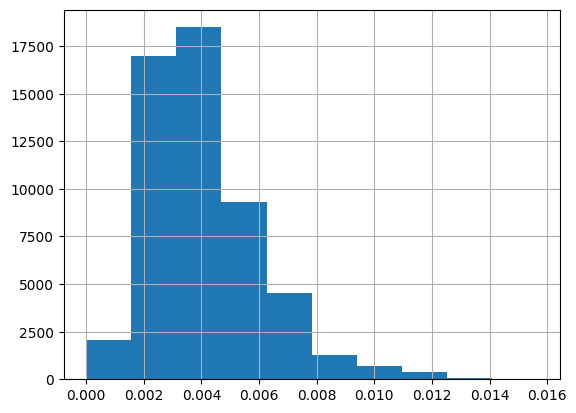

In [60]:
# df_w_price[df_w_price["volatility_6h"] > 0]["volatility_6h"].hist()
# df_w_price[df_w_price["volatility_24h"] > 0]["volatility_24h"].hist()

# df_w_price["trend_6h"].hist()
df_w_price["volatility_24h"].hist()

# df_w_price["volatility_6h"].value_counts()

In [44]:
df_w_price["trend_1h"].nunique()
# asset_price_df

1

In [32]:
import os
os.listdir("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw")

['base_wbtc_usdc.csv',
 'base_wbtc_usdt.csv',
 'eth_cbbtc_usdt.csv',
 'eth_cbbtc_usdc.csv',
 'base_weth_usdt.csv',
 'base_wsteth_usdt.csv',
 'base_wsteth_usdc.csv',
 'base_cbbtc_usdt.csv',
 'base_cbbtc_usdc.csv',
 'eth_wbtc_usdc.csv',
 'eth_wbtc_usdt.csv',
 'base_cbbtc_usdc_1.csv',
 'eth_weth_usdt.csv',
 'eth_wsteth_usdt.csv',
 'eth_wsteth_usdc.csv']

In [11]:
import os 

def compute_market_rates(market_params, fee=0.0):
    rate_dict = market_params.get('rate_at_target', {})
    if not rate_dict:
        return {}

    SECONDS_PER_YEAR = 365 * 86400
    TARGET = 0.9
    KD = 4.0

    utils = np.arange(0, 1.01, 0.01)
    util_percent = utils * 100

    result = {}
    for ts, rate_wad in rate_dict.items():
        if rate_wad is None:
            continue
        rate_per_sec = rate_wad / 1e18
        e = np.where(
            utils <= TARGET,
            (utils - TARGET) / TARGET,
            (utils - TARGET) / (1 - TARGET)
        )
        curve = np.where(
            utils <= TARGET,
            (1 - 1/KD) * e + 1,
            (KD - 1) * e + 1
        )
        borrow_rate_ps = rate_per_sec * curve
        supply_rate_ps = borrow_rate_ps * utils * (1 - fee)
        borrow_apr = borrow_rate_ps * SECONDS_PER_YEAR
        supply_apr = supply_rate_ps * SECONDS_PER_YEAR
        result[int(ts)] = [
            [util_percent[i], borrow_apr[i], supply_apr[i]]
            for i in range(len(utils))
        ]

    return result

def build_enriched_df(name, raw_df, market_meta, asset_data, loan_asset_data, market_irm_rates):
    metrics = calculate_metrics(
        raw_df[raw_df["datetime"].astype(str) < "2027-01-01"],
        use_collateral=False,
        # irm_data=market_meta["irm_curve"],
        irm_history=market_irm_rates,
        asset_data=asset_data,
        loan_asset_data=loan_asset_data
    )

    enriched = raw_df.merge(metrics.drop(columns=["timestamp", "datetime"]))
    asset_price_df = pd.DataFrame(asset_meta["historical_price"], columns=["timestamp", "price"]).dropna()
    enriched = add_user_ltv(enriched, market_data=market_meta)
    enriched = add_price_features(enriched, asset_price_df)

    enriched.to_csv(f"/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/{name}.csv", index=False)


raw_path = "/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw"
# for file in tqdm(os.listdir(raw_path)):
for file in tqdm(["eth_rlp_usdc.csv"]):
    print("processing file", file)
    # if "base" in file:
    #     continue
    raw_df = pd.read_csv(raw_path + "/" + file)
    print(raw_df.shape)
    # raw_df = raw_df[:200_000]
    address = raw_df["market_address"].unique()[0]
    market_meta = markets_meta[address]
    market_irm_rates = compute_market_rates(market_meta)
    print(address)
    asset_meta = assets_meta[market_meta["collateral_asset_address"]]
    loan_asset_meta = assets_meta[market_meta["loan_asset_address"]]
    loan_asset_meta["decimals"] = 6
    build_enriched_df(
        file.split(".")[0],
        raw_df,
        market_meta,
        asset_meta,
        loan_asset_meta,
        market_irm_rates,
    )



# build_enriched_df(
#     "eth_cbbtc_usdt",
#     df,
#     market_meta
# )

  0%|          | 0/1 [00:00<?, ?it/s]

processing file eth_rlp_usdc.csv
(56185, 11)
0xe1b65304edd8ceaea9b629df4c3c926a37d1216e27900505c04f14b2ed279f33
Added interest rates
Added coll price
Added loan asset price


100%|██████████| 1/1 [00:25<00:00, 25.25s/it]


In [3]:
import os
import pandas as pd
markets_list = []
raw_path = "/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw"

for file in os.listdir(raw_path):
    markets_list.append(
        pd.read_csv(raw_path + "/" + file)["market_address"].unique()[0]
    )

In [5]:
f"da: {markets_list}"

"da: ['0x3a85e619751152991742810df6ec69ce473daef99e28a64ab2340d7b7ccfee49', '0xa921ef34e2fc7a27ccc50ae7e4b154e16c9799d3387076c421423ef52ac4df99', '0x9103c3b4e834476c9a62ea009ba2c884ee42e94e6e314a26f04d312434191836', '0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8dbd34ad64a658b2b05bca', '0x64d65c9a2d91c36d56fbc42d69e979335320169b3df63bf92789e2c8883fcc64', '0xdbffac82c2dc7e8aa781bd05746530b0068d80929f23ac1628580e27810bc0c5', '0xe7e9694b754c4d4f7e21faf7223f6fa71abaeb10296a4c43a54a7977149687d2', '0xb323495f7e4148be5643a4ea4a8221eef163e4bccfdedc2a6f4696baacbc86cc', '0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8dbd34ad64a658b2b05bca', '0x9103c3b4e834476c9a62ea009ba2c884ee42e94e6e314a26f04d312434191836', '0x3a85e619751152991742810df6ec69ce473daef99e28a64ab2340d7b7ccfee49', '0xa921ef34e2fc7a27ccc50ae7e4b154e16c9799d3387076c421423ef52ac4df99', '0x9103c3b4e834476c9a62ea009ba2c884ee42e94e6e314a26f04d312434191836', '0xdbffac82c2dc7e8aa781bd05746530b0068d80929f23ac1628580e27810bc0c5', '0xe7e9694b754

In [ ]:
df["type"].unique()
df

hash  \
0     0xa5d64f0a0881150ac9e209470f4378f897d812965951...   
1     0x769086d9812ed5f61210015e00744e7597370e9d4812...   
2     0x0bd7a21adc448f0be70f9aeff1810e4aadf81594cea1...   
3     0x5773092976efbd11bac571c4a18dec90c787d40014ad...   
4     0x8eac7ccf48aecf50b6ac24ea1fb2bc8993f5d4f92618...   
...                                                 ...   
1278  0xec944a4c9ffd4d229fd547cf65025ebf19c116c7de7b...   
1279  0xbfde4a6f74683ed2ecd0a8075eafa4a85222ea014370...   
1280  0x06f5d7b58441fe2f20e6c55e36bcfe4d785bc3cc66e3...   
1281  0x06f5d7b58441fe2f20e6c55e36bcfe4d785bc3cc66e3...   
1282  0xf46942b5302f3abc9a3c3a1e17209820e274165336a1...   

                          type   timestamp  \
0                 MarketSupply  1761446903   
1       MarketSupplyCollateral  1761446927   
2                 MarketBorrow  1761446939   
3                 MarketSupply  1761763931   
4                 MarketSupply  1761769415   
...                        ...         ...   
1278              MarketSupply  1767695531   
1279  MarketWithdrawCollateral  1767708419   
1280               MarketRepay  1767709355   
1281  MarketWithdrawCollateral  1767709355   
1282               MarketRepay  1767709523   

                                    user_address       assets    assets_usd  \
0     0xB47f11484e19f1914D32fd393b17671221C10F1F      1000000      1.000362   
1     0xB47f11484e19f1914D32fd393b17671221C10F1F         3000      3.354816   
2     0xB47f11484e19f1914D32fd393b17671221C10F1F      1000000      1.000362   
3     0xB47f11484e19f1914D32fd393b17671221C10F1F       200000      0.200042   
4     0x79FD640000F8563A866322483524a4b48f1Ed702  10011631050  10015.332011   
...                                          ...          ...           ...   
1278  0x8CB3649114051cA5119141a34C200D65dc0Faa73  79832402742  79803.968192   
1279  0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169     20000000  18742.120300   
1280  0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169   8774062107   8771.022130   
1281  0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169     15000000  14056.590225   
1282  0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169   8000000000   7997.228214   

              market             datetime  \
0     eth_cbbtc_usdt  2025-10-26 02:48:23   
1     eth_cbbtc_usdt  2025-10-26 02:48:47   
2     eth_cbbtc_usdt  2025-10-26 02:48:59   
3     eth_cbbtc_usdt  2025-10-29 18:52:11   
4     eth_cbbtc_usdt  2025-10-29 20:23:35   
...              ...                  ...   
1278  eth_cbbtc_usdt  2026-01-06 10:32:11   
1279  eth_cbbtc_usdt  2026-01-06 14:06:59   
1280  eth_cbbtc_usdt  2026-01-06 14:22:35   
1281  eth_cbbtc_usdt  2026-01-06 14:22:35   
1282  eth_cbbtc_usdt  2026-01-06 14:25:23   

                                         market_address  
0     0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
1     0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
2     0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
3     0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
4     0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
...                                                 ...  
1278  0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
1279  0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
1280  0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
1281  0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  
1282  0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...  

[1283 rows x 9 columns]

In [67]:
apollo_metrics.head(2)

hash                    type  \
0  0xbf65679043e7f6fc287c16b098710a11428d00eda045...            MarketSupply   
1  0x539bdf1cfe49dd02f40f4ea84d6c834108d751e5101d...  MarketSupplyCollateral   

    timestamp                                user_address  \
0  1756976963  0x7f7A70b5B584C4033CAfD52219a496Df9AFb1af7   
1  1756977431  0x7399436c47E4A1baD90499d87dfAa117CBF08b96   

                assets  assets_usd  liquidated_assets  liquidated_assets_usd  \
0              1000000    0.999712                  0                      0   
1  2000000000000000000    2.030428                  0                      0   

             market             datetime  \
0  eth_mapollo_usdc  2025-09-04 09:09:23   
1  eth_mapollo_usdc  2025-09-04 09:17:11   

                                      market_address  total_supply_before  \
0  0x031c7333014af51e4fd18031d14e4eaada58348cde3f...                  0.0   
1  0x031c7333014af51e4fd18031d14e4eaada58348cde3f...                  1.0   

   total_borrow_before  total_supply_after  total_borrow_after  \
0                  0.0                 1.0                 0.0   
1                  0.0                 1.0                 0.9   

   utilization_before  utilization_after  tx_actions  borrow_rate_before  \
0                 0.0                0.0           1            0.009608   
1                 0.0                0.9           2            0.009608   

   supply_rate_before  borrow_rate_after  supply_rate_after  collateral_price  \
0                 0.0           0.009608           0.000000          1.015214   
1                 0.0           0.038432           0.034588          1.015214   

   loan_asset_price  collateral_before  collateral_value_before  debt_before  \
0          0.999712                0.0                      0.0          0.0   
1          0.999712                0.0                      0.0          0.0   

   ltv_before  collateral_after  collateral_value_after  debt_after  \
0         0.0               0.0                0.000000    0.000000   
1         0.0               2.0                2.030428    0.899741   

   ltv_after  health_factor_before  health_factor_after            event_type  \
0   0.000000                   0.0             0.000000  loan_position_supply   
1   0.443129                   0.0             1.940186         position_open   

   vault_flg  volatility_1h  drawdown_1h  trend_1h  volatility_6h  \
0      False              0            0         0            0.0   
1      False              0            0         0            0.0   

   drawdown_6h  trend_6h  volatility_24h  drawdown_24h  trend_24h  
0          0.0       0.0             0.0           0.0        0.0  
1          0.0       0.0             0.0           0.0        0.0

In [82]:
apollo_metrics = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/eth_mapollo_usdc.csv")

# _ = plot_daily_metrics_express(apollo_metrics, ["total_supply_after", "total_borrow_after"], agg_func="mean")
_ = plot_daily_metrics_express(apollo_metrics, ["borrow_rate_after", "supply_rate_after"], agg_func="mean")


In [83]:
apollo_metrics[apollo_metrics["vault_flg"] == False]["user_address"].value_counts()

apollo_metrics[apollo_metrics["user_address"] == "0x2b6D91d5C378F3FFBeeF113A5DdcB98b5FAC1119"][[
    "datetime",
    "type",
    "debt_after",
    "collateral_value_after",
    "ltv_after",
]]

datetime                      type     debt_after  \
6    2025-10-23 06:38:11    MarketSupplyCollateral       0.000000   
7    2025-10-23 06:40:59              MarketBorrow  328033.205995   
8    2025-10-23 06:47:35    MarketSupplyCollateral  328033.205995   
9    2025-10-23 06:48:23              MarketBorrow  596036.211486   
10   2025-10-23 06:51:35    MarketSupplyCollateral  814994.574211   
11   2025-10-23 06:51:35              MarketBorrow  814994.574211   
12   2025-10-23 06:54:35              MarketBorrow  924979.254583   
13   2025-10-23 06:54:35    MarketSupplyCollateral  924979.254583   
95   2025-11-05 03:11:59               MarketRepay  744945.449340   
428  2026-02-06 07:25:47  MarketWithdrawCollateral  744981.151728   
433  2026-02-09 03:22:59               MarketRepay  632931.114888   
434  2026-02-09 03:31:23  MarketWithdrawCollateral  632931.114888   
463  2026-02-12 05:41:23               MarketRepay  151686.910128   
464  2026-02-12 09:53:35  MarketWithdrawCollateral  151686.910128   

     collateral_value_after  ltv_after  
6              4.015654e+05   0.000000  
7              4.015654e+05   0.817000  
8              7.296443e+05   0.449642  
9              7.296443e+05   0.817000  
10             9.976846e+05   0.817000  
11             9.976846e+05   0.817000  
12             1.216673e+06   0.760359  
13             1.216673e+06   0.760359  
95             1.222401e+06   0.609545  
428            1.136399e+06   0.655675  
433            1.136399e+06   0.557057  
434            8.181904e+05   0.773706  
463            8.181904e+05   0.185425  
464            6.060515e+05   0.250287

In [24]:
df1 = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/base_cbbtc_usdc.csv")

_ = plot_daily_metrics_express(df1, ["supply_rate_after", "borrow_rate_after"], agg_func="last")
# _ = plot_daily_metrics_express(df1, ["total_supply_after", "total_borrow_after"], agg_func="last")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/base_cbbtc_usdc.csv'

In [49]:
df1.head(2)

hash                    type  \
0  0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...            MarketSupply   
1  0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...  MarketSupplyCollateral   

    timestamp                                user_address   assets  \
0  1726145495  0x29d4CDFee8F533af8529A9e1517b580E022874f7  1000000   
1  1726145495  0x29d4CDFee8F533af8529A9e1517b580E022874f7     5000   

   assets_usd          market             datetime  \
0    0.999934  eth_cbbtc_usdc  2024-09-12 12:51:35   
1    2.903950  eth_cbbtc_usdc  2024-09-12 12:51:35   

                                      market_address  total_supply_before  \
0  0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...                  0.0   
1  0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...                  0.0   

   total_borrow_before  total_supply_after  total_borrow_after  \
0                  0.0       166666.666667       148333.333333   
1                  0.0       166666.666667       148333.333333   

   utilization_before  utilization_after  tx_actions  borrow_rate_before  \
0                 0.0               0.89           3            0.010097   
1                 0.0               0.89           3            0.010097   

   supply_rate_before  borrow_rate_after  supply_rate_after  collateral_price  \
0                 0.0           0.040662           0.036189               NaN   
1                 0.0           0.040662           0.036189               NaN   

   loan_asset_price  collateral_before  collateral_value_before  debt_before  \
0          0.999641                0.0                      NaN          0.0   
1          0.999641                0.0                      NaN          0.0   

   ltv_before  collateral_after  collateral_value_after  debt_after  ltv_after  
0         0.0           0.00005                     NaN     0.88968        0.0  
1         0.0           0.00005                     NaN     0.88968        0.0